In [115]:
from sklearn.model_selection import train_test_split
# from sklearn.manifold import LocallyLinearEmbedding
from sklearn.datasets import load_iris, load_digits
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray

In [116]:
data = load_iris()
x = data.data
y = data.target


In [117]:
# # Create and fit LLE model
# lle = LocallyLinearEmbedding(n_neighbors=20, n_components=2)
# X_transformed = lle.fit_transform(x)
# print(X_transformed.shape)

# # Visualize the results
# plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y)
# plt.title('LLE Projection of Iris Dataset')
# plt.xlabel('Component 1')
# plt.ylabel('Component 2')
# plt.show()

<div class="markdown prose w-full break-words dark:prose-invert dark"><p>The "Singular matrix" error typically occurs when you try to compute the inverse of a singular or nearly singular matrix. In the context of Locally Linear Embedding (LLE) or similar algorithms, it often means that the local neighborhood for a particular point is not diverse enough, leading to a poorly conditioned matrix.</p><p>To address this issue, you can add a small regularization term to the diagonal of the matrix <code>G</code> before computing the inverse. This regularization helps stabilize the inversion process and avoid singularities. The modified line would look like this:</p><pre><div class="bg-black rounded-md"><div class="flex items-center relative text-gray-200 bg-gray-800 dark:bg-token-surface-primary px-4 py-2 text-xs font-sans justify-between rounded-t-md"></div><div class="p-4 overflow-y-auto"><code class="!whitespace-pre hljs language-python">G_inv = np.linalg.inv(G + <span class="hljs-number">1e-4</span> * np.eye(G.shape[<span class="hljs-number">0</span>]))
</code></div></div></pre><p>Here, <code>1e-4</code> is a small value that you can adjust based on your specific dataset and requirements.</p><p>Feel free to experiment with different values for the regularization term (e.g., <code>1e-4</code>) to find a suitable value for your specific dataset. Adjusting this value can help balance the trade-off between stability and the influence of the regularization term.</p></div>

In [118]:
# LLE Implementation
# data is a matrix of n*d : n data row and d coloumn for every feature


class LocallyLinearEmbedding:
    n_component: int
    n_neighbours: int
    data: NDArray
    weghits: NDArray
    
    def __init__(self, n_component, n_neighbours) -> None:
        self.n_component = n_component
        self.n_neighbours = n_neighbours
        
    def fit_transform(self, data):
        self.data = data
        self.LinearReconustruction()
        return self.LinearEmbedding()
        
    
    def LinearEmbedding(self):
        w_size = self.weghits.shape[0]
        M = np.eye(w_size) - self.weghits
        M = M.T @ M
        eigenvalues, eigenvectors = np.linalg.eig(M)
        indices = np.argsort(eigenvalues)[1:self.n_component+1]
        Y = eigenvectors[:, indices]
        return Y
    
    def LinearReconustruction(self):
        w = [] # wight is a mtrix with n*n_neighbours size.
        ones = np.ones(self.n_neighbours).reshape(-1,1)
        for i in range(self.data.shape[0]):
            d = self.data[i].reshape(-1, 1)
            knn, knn_i = self.KNN(i)
            G = d @ ones.T - knn.T
            G = G.T @ G
            G_inv = np.linalg.inv(G + 1e-4 * np.eye(G.shape[0]))
            w_i = ((G_inv @ ones)/(ones.T @ G_inv @ ones)).squeeze()
            w_i = self.ReconstructWeights(w_i, knn_i)
            w.append(w_i)
        self.weghits = np.array(w)
        return w
    
    def ReconstructWeights(self, w, knn_i):
        res = np.zeros((self.data.shape[0]))
        for i in range(res.shape[0]):
            for index in range(len(knn_i)):
                if knn_i[index] == i:
                    res[i] = w[index]
                    break
        return res
        
    def KNN(self, index):
        neighbors_t = {}
        for i in range(self.data.shape[0]):
            if not i == index:
                neighbors_t[i] = np.linalg.norm(self.data[i] - self.data[index])
                # print(f'{self.data[i]}:{neighbors_t[i]}')
        neighbors_t = dict(sorted(neighbors_t.items(), key=lambda item: item[1]))
        neighbors = []
        neighbors_i = []
        for index,key in enumerate(neighbors_t):
            neighbors.append(self.data[key]) # data of key
            neighbors_i.append(key) # key itself
            if index + 1 == self.n_neighbours:
                break
        return np.array(neighbors), np.array(neighbors_i)

In [119]:
# LLE = LocallyLinearEmbedding(2, 3)
# x_LLE = [4, 5, 10, 4, 3, 11, 14 , 8, 10, 12]
# y_LLE = [21, 19, 24, 17, 16, 25, 24, 22, 21, 21]
# classes = [0, 0, 1, 0, 0, 1, 1, 0, 1, 1]
# selected = 7
# LLE.data = np.column_stack((x_LLE,y_LLE))
# print(LLE.data[selected])
# n, _=LLE.KNN(selected)
# for i in n:
#     print(i)
#     plt.scatter(i[0], i[1], c='green', alpha=.8, zorder=100, label='neighbours')
# plt.scatter(LLE.data[selected][0], LLE.data[selected][1], c='red', zorder=100, label='selected')
# plt.scatter(x_LLE, y_LLE, c=classes, label='all points')
# plt.legend()
# plt.show()

(150, 4)
(150, 2)


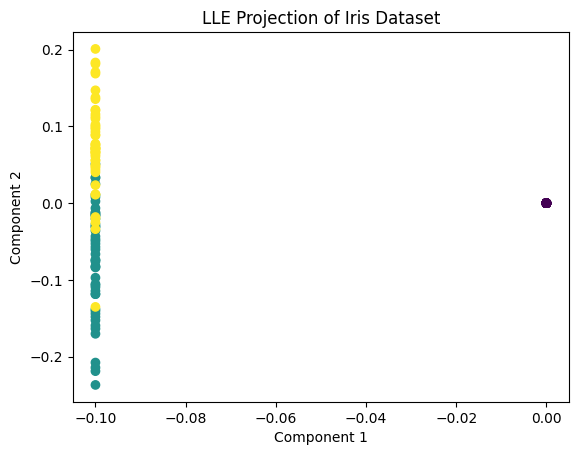

In [120]:
X_transformed = LocallyLinearEmbedding(2, 6).fit_transform(x)

print(x.shape)
print(X_transformed.shape)

# Visualize the results
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y)
plt.title('LLE Projection of Iris Dataset')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()